In [1]:
import numpy as np
import pandas as pd

In [2]:
human_data = pd.read_table('/home/varun/Back up/digitalV/DNA/human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [3]:
human_data.shape

(4380, 2)

In [4]:
human_data['class'].unique()

array([4, 3, 5, 2, 6, 0, 1])

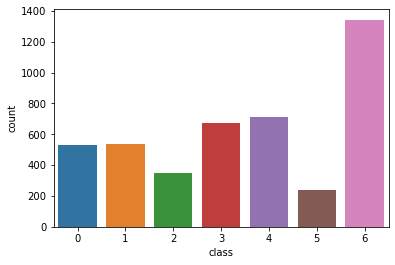

In [5]:
import seaborn as sns
sns.countplot(human_data['class'])

In [6]:
dog_data = pd.read_table('/home/varun/Back up/digitalV/DNA/dog_data.txt')
chimp_data = pd.read_table('/home/varun/Back up/digitalV/DNA/chimp_data.txt')
chimp_data.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


Treating DNA sequence as a "language", otherwise known as k-mer counting

A challenge that remains is that none of these above methods results in vectors of uniform length, and that is a requirement for feeding data to a classification or regression algorithm. So with the above methods you have to resort to things like truncating sequences or padding with "n" or "0" to get vectors of uniform length.

DNA and protein sequences can be viewed metaphorically as the language of life. The language encodes instructions as well as function for the molecules that are found in all life forms. The sequence language analogy continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides (motifs) are words, and nucleotide bases and amino acids are the alphabet.

The method I use here is simple and easy. I first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if I use "words" of length 6 (hexamers), “ATGCATGCA” becomes: ‘ATGCAT’, ‘TGCATG’, ‘GCATGC’, ‘CATGCA’. Hence our example sequence is broken down into 4 hexamer words.


In [7]:
def getKmers(sequence,size=6):
    return [sequence[x: x+6].lower() for x in range(len(sequence) - size + 1)]

In [8]:
human_data['words'] = human_data['sequence'].apply(lambda x : getKmers(x))
dog_data['words'] = dog_data['sequence'].apply(lambda x : getKmers(x))
chimp_data['words'] = chimp_data['sequence'].apply(lambda x : getKmers(x))

In [9]:
human_data = human_data.drop('sequence',axis = 1)
dog_data = dog_data.drop('sequence',axis = 1)
chimp_data = chimp_data.drop('sequence',axis = 1)

In [10]:
chimp_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,4,"[atggcc, tggcct, ggcctc, gcctcg, cctcgc, ctcgc..."
3,4,"[atggcc, tggcct, ggcctc, gcctcg, cctcgc, ctcgc..."
4,6,"[atgggc, tgggca, gggcag, ggcagc, gcagcg, cagcg..."


In [11]:
human_texts = list(human_data['words'])
for text in range(len(human_texts)):
    human_texts[text] = ' '.join(human_texts[text])

In [12]:
dog_texts = list(dog_data['words'])
for text in range(len(dog_texts)):
    dog_texts[text] = ' '.join(dog_texts[text])
    
chimp_texts = list(chimp_data['words'])
for text in range(len(chimp_texts)):
    chimp_texts[text] = ' '.join(chimp_texts [text])

In [ ]:
##FEATURE EXTRACTION(COUNTVECTORIZER)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(4,4))

X = count_vect.fit_transform(human_texts)
X_dogs = count_vect.fit_transform(dog_texts)
X_chimps = count_vect.fit_transform(chimp_texts)

In [14]:
X.shape

(4380, 232414)

In [15]:
y = human_data.iloc[:,0].values
y_dog = dog_data.iloc[:,0].values
y_chimp = chimp_data.iloc[:,0].values
y_dog[0:9]

array([4, 4, 6, 6, 0, 6, 0, 0, 0])

In [ ]:
##Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_dog_train, X_dog_test, y_dog_train, y_dog_test = train_test_split(X_dogs, y_dog, test_size=0.2, random_state=42)
X_chimp_train, X_chimp_test, y_chimp_train, y_chimp_test = train_test_split(X_chimps, y_chimp, test_size=0.2, random_state=42)

In [17]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [ ]:
## Model Building For Human Data

In [18]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [19]:
parameters = {
    'alpha' : [0.01,0.1,0.5,0.8,1,3]
}
naive_m = MultinomialNB()

gs = GridSearchCV(naive_m,parameters,cv=6)
gs_fit = gs.fit(X_train,y_train)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score',ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
2,0.213289,0.014658,0.029885,0.003512,0.5,{'alpha': 0.5},0.964041,0.976027,0.960616,0.965753,0.953767,0.976027,0.966039,0.007996,1
5,0.209377,0.002740,0.028051,0.000421,3,{'alpha': 3},0.964041,0.976027,0.962329,0.958904,0.950342,0.970890,0.963756,0.008237,2
3,0.214635,0.005373,0.028655,0.001647,0.8,{'alpha': 0.8},0.962329,0.972603,0.950342,0.964041,0.950342,0.974315,0.962329,0.009482,3
4,0.209105,0.004163,0.028363,0.002027,1,{'alpha': 1},0.962329,0.972603,0.948630,0.962329,0.950342,0.974315,0.961758,0.009820,4
1,0.202021,0.002497,0.027617,0.000821,0.1,{'alpha': 0.1},0.967466,0.979452,0.945205,0.950342,0.946918,0.976027,0.960902,0.013961,5


In [20]:
predictions = gs_fit.predict(X_test)
predictions[0:5]

array([2, 0, 4, 6, 3])

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('The accuracy score for human data is : ',accuracy_score(y_test,predictions) )

The accuracy score for human data is :  0.9863013698630136


In [22]:
print('Confusion matrix for human data is : ',confusion_matrix(y_test,predictions) )

Confusion matrix for human data is :  [[100   0   0   0   2   0   0]
 [  0 104   0   0   0   0   2]
 [  0   0  78   0   0   0   0]
 [  0   0   0 124   1   0   0]
 [  0   0   0   0 146   0   3]
 [  0   0   0   0   0  51   0]
 [  1   0   0   1   2   0 261]]


In [23]:
print('classification_report for human data is : \n', classification_report(y_test,predictions) )

classification_report for human data is : 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       102
           1       1.00      0.98      0.99       106
           2       1.00      1.00      1.00        78
           3       0.99      0.99      0.99       125
           4       0.97      0.98      0.97       149
           5       1.00      1.00      1.00        51
           6       0.98      0.98      0.98       265

    accuracy                           0.99       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.99      0.99      0.99       876



In [ ]:
## Model Building For Dog Data

In [24]:
naive_m_dog = MultinomialNB()

gs_dog = GridSearchCV(naive_m_dog,parameters,cv=6)
gs_fit_dog = gs_dog.fit(X_dog_train,y_dog_train)
pd.DataFrame(gs_fit_dog.cv_results_).sort_values('mean_test_score',ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
2,0.075963,0.002686,0.011381,0.000929,0.5,{'alpha': 0.5},0.700000,0.690909,0.743119,0.651376,0.688073,0.678899,0.692063,0.027434,1
3,0.074333,0.003320,0.010884,0.000860,0.8,{'alpha': 0.8},0.700000,0.663636,0.743119,0.642202,0.697248,0.678899,0.687517,0.031728,2
4,0.075539,0.003366,0.010551,0.000507,1,{'alpha': 1},0.690909,0.663636,0.743119,0.651376,0.697248,0.660550,0.684473,0.030946,3
1,0.081988,0.012834,0.012229,0.002686,0.1,{'alpha': 0.1},0.645455,0.654545,0.715596,0.660550,0.743119,0.633028,0.675382,0.039894,4
5,0.071808,0.002111,0.011598,0.001567,3,{'alpha': 3},0.627273,0.663636,0.715596,0.651376,0.706422,0.642202,0.667751,0.032560,5


In [25]:
gs_fit_dog.fit(X_dog_train,y_dog_train)

GridSearchCV(cv=6, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 0.8, 1, 3]})

In [26]:
predictions_dog = gs_fit_dog.predict(X_dog_test)

In [27]:
print('The accuracy score for dog data is : ',accuracy_score(y_dog_test,predictions_dog) )

The accuracy score for dog data is :  0.7134146341463414


In [28]:
print('Confusion matrix for dog data is : ',confusion_matrix(y_dog_test,predictions_dog) )

Confusion matrix for dog data is :  [[18  0  0  0  0  3  6]
 [ 0 15  0  1  0  1  2]
 [ 0  0 12  0  0  0  2]
 [ 1  0  0 11  0  0  4]
 [ 4  0  0  4  8  1  6]
 [ 2  0  0  0  0  8  3]
 [ 0  1  0  4  2  0 45]]


In [29]:
print('classification_report for dog data is : \n', classification_report(y_dog_test,predictions_dog) )

classification_report for dog data is : 
               precision    recall  f1-score   support

           0       0.72      0.67      0.69        27
           1       0.94      0.79      0.86        19
           2       1.00      0.86      0.92        14
           3       0.55      0.69      0.61        16
           4       0.80      0.35      0.48        23
           5       0.62      0.62      0.62        13
           6       0.66      0.87      0.75        52

    accuracy                           0.71       164
   macro avg       0.75      0.69      0.70       164
weighted avg       0.74      0.71      0.71       164



In [ ]:
## Model Building For chimpanzee Data

In [30]:
naive_m_chimp = MultinomialNB(alpha=0.5)
naive_m_chimp.fit(X_chimp_train,y_chimp_train)

MultinomialNB(alpha=0.5)

In [31]:
predictions_chimp = naive_m_chimp.predict(X_chimp_test)

In [32]:
print('The accuracy score for chimpanzee data is : ',accuracy_score(y_chimp_test,predictions_chimp))

The accuracy score for chimpanzee data is :  0.9109792284866469


In [33]:
print('Confusion matrix for chimpanzee data is : ',confusion_matrix(y_chimp_test,predictions_chimp))

Confusion matrix for chimpanzee data is :  [[ 25   0   0   1   1   1   0]
 [  0  38   0   1   0   0   0]
 [  0   0  26   0   0   0   1]
 [  0   0   0  41   2   0   0]
 [  0   1   0   5  44   0   2]
 [  3   0   0   2   3  19   2]
 [  0   0   0   5   0   0 114]]


In [34]:
print('classification_report for chimpanzee data is : \n', classification_report(y_chimp_test,predictions_chimp))

classification_report for chimpanzee data is : 
               precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.97      0.97      0.97        39
           2       1.00      0.96      0.98        27
           3       0.75      0.95      0.84        43
           4       0.88      0.85      0.86        52
           5       0.95      0.66      0.78        29
           6       0.96      0.96      0.96       119

    accuracy                           0.91       337
   macro avg       0.91      0.89      0.90       337
weighted avg       0.92      0.91      0.91       337

